# 【自前AI講座】決定木の理論／数式／コード実装

---

## 理論と数式

In [1]:
import matplotlib.pyplot as plt

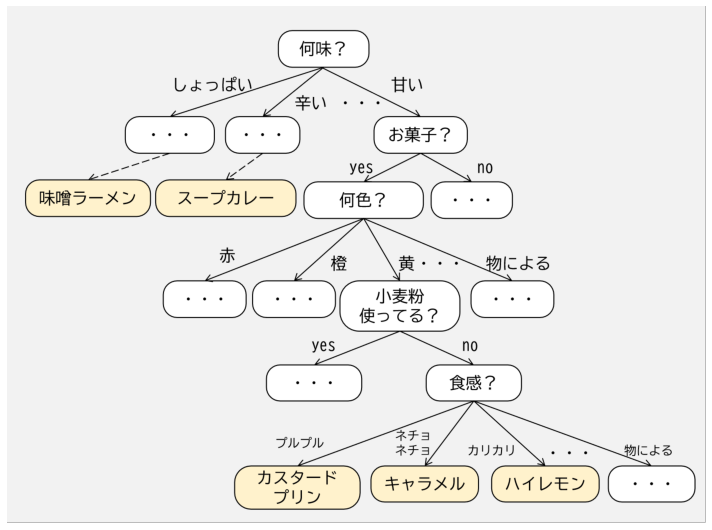

In [8]:
plt.figure(figsize=(10,10), facecolor="white")
plt.imshow(plt.imread("./dt-00.png"))
plt.axis("off")
plt.tight_layout()
plt.show()

上図のように，決定木では説明変数についていくつかのふるい分け（質問）を学習し，目的変数のラベルを推測するように学習していきます．  
例ではクラスラベルを予測していますが，数値などの連続値でも，ふるい分けの条件を例えば「10 以上？」といったものを用いることで回帰問題も扱うことができます．  
学習する中身としては，

- 決定木の根（ルート）からスタート
- 分割した集合の要素についてのばらつきの減少を意味する情報利得 (information gain) が最大となる特徴量でデータを分割
- 葉（リーフ）が純粋になる，すなわち，分割されたデータのばらつきの減少がなくなるまで，この分割を子ノード（分岐条件）ごとに繰り返す

という流れです．  
リーフが純粋になることは，各リーフの要素が全て同じクラスになることと同義ですが，実際そこまで繰り返し計算を行い木構造を大きくしてしまうと，多くのノードを持った深い木構造になり，結果過学習を起こしやすくなってしまいます．  
従って，決定木の最大の深さに上限を設けたり，木構造を剪定 (prune) する必要があります．

では，どうやって情報利得（ゲインと呼ぶのが一般的？）が最大となる特徴量でデータを分割するかということについて，以下で説明していきます．  
最大化するにあたって必要な最適化計算で用いる目的関数を次で定義します．

$$
IG(D_p, f) = I(D_p) - \sum_{j=1}^{m} \frac{N_j}{N_p} I (D_j)
$$

ここで，$f$ は分割を行う特徴量，$D_p$ は親のデータセット，$D_j$ は $j$ 番目の子ノードのデータセット，$I$ は不純度 (impurity) を数値化したもの，$N_p$ は親ノードのサンプルの総数，$N_j$ は $j$ 番目の子ノードのサンプルの個数を表します．  
この数式は，情報利得は「親ノードの不純度」と「子ノードの不順度の合計」の差 のみで定義されることを表しており，子ノードの不順度が小さいほど情報利得は大きくなります．  
考え方としては至ってシンプルですね．

先の例や数式では yes / no 疑問文だけでなく複数回答できるような質問とそれの回答としての $m$ 個のノードを対象としていました．  
しかし，探索空間の単純化や計算量低減を目的として，また，scikit-learn を含むほとんどのライブラリは yes / no の分岐だけで構成される二分決定木 (binary decision tree) を採用しているため，これからは二分決定木について説明を行っていきます．  
まず，先の式を二分決定木に適応させると，

$$
IG(D_p, f) = I(D_p) - \frac{N_{left}}{N_p} I (D_{left}) - \frac{N_{right}}{N_p} I (D_{right})
$$

となります．  
ここで，下付き文字の $left, right$ は二分決定木で分かれた２つの子ノードに関する変数であることを表しています．  
二分決定木における不純度 $I$ の指標や分割条件は，ジニ不純度 (Gini impurity)，エントロピー (entropy)，分類誤差 (classification error) が良く使用されます．  
以下，ジニ不純度を $I_G$，エントロピーを $I_H$，分類誤差を $I_E$ と記載します．  
エントロピーは次式で書き表されます．

$$
I_H(t) = - \sum_{i=1}^{c} p(i|t) \log_2p(i|t)
$$

ここで，$i$ はクラス，$t$ はある特定のノード，$p(i|t)$ は $t$ において $i$ に属するサンプルの割合を表します．  
ノードのサンプルが全て同じクラスである場合は $\log_21 = 0$ なのでエントロピーが 0 になります．  
エントロピーが最大になるのは，各クラスが一様に分布している場合です．  
従って，エントロピーは相互の情報量（２つの確率の相互依存度）が最大化するように試みるような分割条件を与えます．

ジニ不純度は次式で書き表されます．

$$
I_G(t) = - \sum_{i=1}^{c} p(i|t) (1 - p(i|t)) = 1 - \sum_{i=1}^{c} p(i|t)^2
$$

ジニ不純度は，直感的には誤分類の確率を最小化する分割条件を与えます．  
エントロピーと同様でジニ不純度が最大になるのはクラスが完全に混合されている場合です．

分類誤差は次式で書き表されます．

$$
I_E(t) = 1 - \max{\left( p(i|t) \right)}
$$

分類誤差については，ノードのクラス確率の変化についてあまり敏感に作用しないため，実際には分割条件として使用されることは少ないです．

---

## コード実装例

今回も機械学習ライブラリの scikit-learn を使います．  
決定木は sklearn.tree に収録されており，クラス分類であれば sklearn.tree.DecisionTreeClassifier，回帰であれば sklearn.tree.DecisionTreeRegressor を用います．

DecisionTreeClassifier (https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

```
class sklearn.tree.DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0)
```

| パラメータ名 | 初期値 | 型／取りうる値 | 説明 |
| - | - | - | - |
| criterion | "gini" | "gini", "entropy", "log_loss" | - |
| splitter | "best" | "best", "random" | - |
| max_depth | None | int | - |
| min_samples_split | 2 | int, float | - |
| min_samples_leaf | 1 | int, float | - |
| min_weight_fraction_leaf | 0.0 | float | - |
| max_features | None | int, float, "sqrt", "log2" | - |
| random_state | None | int | 乱数シード値 |
| max_leaf_nodes | None | int | - |
| min_impurity_decrease | 0.0 | float | - |
| class_weight | None | dict, list, "balanced" | - |
| ccp_alpha | 0.0 | float (>=0) | - |

DecisionTreeRegressor (https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)

```
class sklearn.tree.DecisionTreeRegressor(*, criterion='squared_error', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, ccp_alpha=0.0)
```

| パラメータ名 | 初期値 | 型／取りうる値 | 説明 |
| - | - | - | - |
| criterion | "squared_error" | "squared_error", "friedman_mse", "absolute_error", "poisson" | - |
| splitter | "best" | - | - |
| max_depth | None | - | - |
| min_samples_split | 2 | - | - |
| min_samples_leaf | 1 | - | - |
| min_weight_fraction_leaf | 0.0 | - | - |
| max_features | None | - | - |
| random_state | None | - | - |
| max_leaf_nodes | None | - | - |
| min_impurity_decrease | 0.0 | - | - |
| ccp_alpha | 0.0 | - | - |

それでは使っていきましょう．  
今回はフリーのデータセットで有名なアヤメ（花）の品種分類データセットの “iris dataset” (https://archive.ics.uci.edu/ml/datasets/Iris) を用います．  
このデータセットについて，説明変数が "sepal_length": がく片の長さ，"sepal_width": がく片の幅，"petal_length": 花びらの長さ，"petal_width": 花びらの幅，目的変数が "species": アヤメの品種名 とした 150 個のデータで構成されています．  
まずは，以下のように，データを読み込みます（インストールされていない場合は "pip install scikit-learn, seaborn" を実行ください）．

     sepal_length  sepal_width  petal_length  petal_width    species
0             5.1          3.5           1.4          0.2     setosa
1             4.9          3.0           1.4          0.2     setosa
2             4.7          3.2           1.3          0.2     setosa
3             4.6          3.1           1.5          0.2     setosa
4             5.0          3.6           1.4          0.2     setosa
..            ...          ...           ...          ...        ...
145           6.7          3.0           5.2          2.3  virginica
146           6.3          2.5           5.0          1.9  virginica
147           6.5          3.0           5.2          2.0  virginica
148           6.2          3.4           5.4          2.3  virginica
149           5.9          3.0           5.1          1.8  virginica

[150 rows x 5 columns]


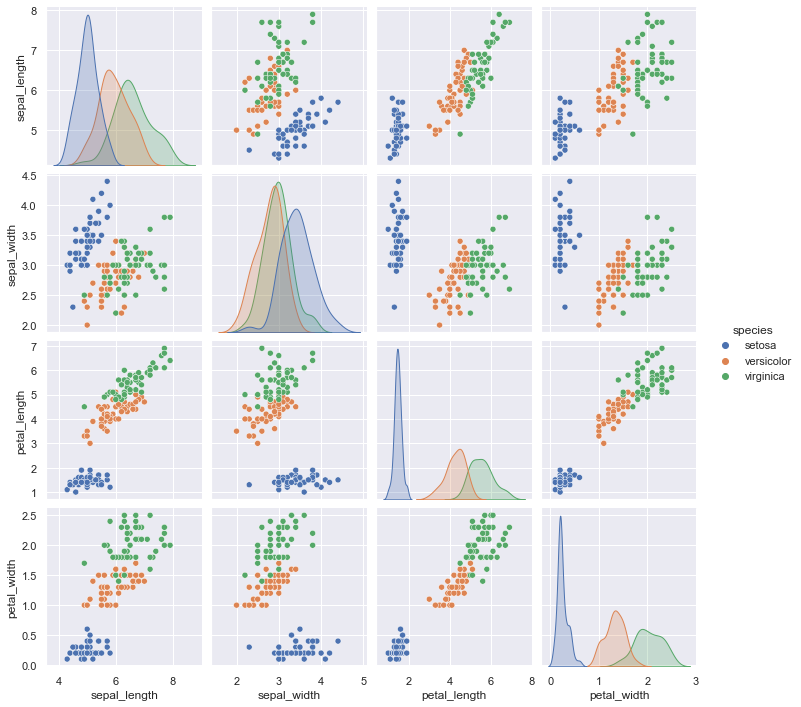

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

iris = sns.load_dataset(name="iris")
print(iris)
sns.pairplot(data=iris, hue="species")
plt.show()

上図から，決定境界を可視化しやすいように２次元の説明変数で分類できそうなデータセットにするため，ここでは "sepal_length" と "sepal_width"，それと目的変数の "species" のみ抜き出して用います．

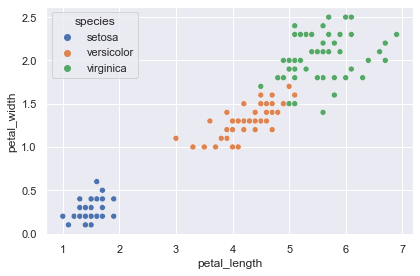

In [10]:
petal = iris[["petal_length", "petal_width", "species"]]
plt.figure(facecolor="white")
sns.scatterplot(data=petal, x="petal_length", y="petal_width", hue="species")
plt.tight_layout()
plt.show()

scikit-learn の学習では，ラベルは 0, 1, ..., と整数にする必要があります．  
このようにラベルなどのカテゴリー変数を数値に変換することをラベルエンコーディング (label encoding) と呼びます．  
お手正の変換用の辞書でも構いませんが，scikit-learn にラベルエンコーディングできる関数が用意されていますので，今回は "sklearn.preprocessing.LabelEncoder" を用いて，説明変数を "x"，目的変数を "y" としておきます．  
さらに，ついでに学習用と検証用でデータ分割しておきます．

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 説明変数のカラムだけ抜き出す
x = petal[[v for v in petal.columns if str(v).startswith("petal_")]]
# "species" カラムをラベルエンコーディングして y と置く
encoder = LabelEncoder()
encoder.fit(petal["species"])
y = encoder.transform(petal["species"])

# データ分割
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, shuffle=True, random_state=0, stratify=y
)
print(y_train[:10])

[0 0 0 0 1 0 2 2 1 2]


目的変数はクラスなので DecisionTreeClassifierを用います．  
また，パラメータについては不純度算出や過学習防止を考慮して criterion="gini", max_depth=4 として計算してみましょう．
使い方は scikit-learn なので，いつも通り「モデル定義」→「fit メソッドで学習」→「predict メソッドで推論」です．

In [13]:
from sklearn import tree

model = tree.DecisionTreeClassifier(criterion="gini", max_depth=4, random_state=0)
model.fit(x_train, y_train)
print(model.predict(x_train)[:10])

[0 0 0 0 1 0 2 2 1 2]


上記出力と y_train[:10] の出力が同等なので，うまく学習できていそうですね．  
学習に用いていない検証用データセットについても推論し，認識精度を算出してみます．

In [14]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(x_test)
print(f"正解ラベル： {y_test}")
print(f"推論結果：   {y_pred}")
print(accuracy_score(y_true=y_test, y_pred=y_pred))

正解ラベル： [0 1 0 2 0 1 2 0 0 1 2 1 1 2 1 2 2 1 1 0 0 2 2 2 0 1 1 2 0 0]
推論結果：   [0 1 0 2 0 1 2 0 0 1 2 1 1 2 1 2 2 1 1 0 0 2 2 1 0 1 1 2 0 0]
0.9666666666666667


ということで，検証用データセットについて認識精度 96.7 % の推論結果となりました．  
実際，どのような決定境界が得られたのか図示してみましょう．  
以下の関数は，インプレス出版の「[第2版］Python機械学習プログラミング 達人データサイエンティストによる理論と実践」 (https://book.impress.co.jp/books/1120101017 ：リンクは第３版) の p.32 ｎ "plot_decision_regions" 関数を参考にしました．

In [15]:
import warnings
from matplotlib.colors import ListedColormap

def plot_decision_regions(
    x: np.ndarray,
    y: np.ndarray,
    model,
    resolution: float = 0.02,
    xlabel: str = None,
    ylabel: str = None,
    figsize: tuple = (6, 5),
    encoder: LabelEncoder = None,
) -> None:
    # キャスト
    x = np.array(x)
    y = np.array(y)
    # マーカーとカラーマップの準備
    markers = ("s", "x", "o", "^", "v")
    colors = ("red", "blue", "lightgreen", "gray", "cyan")
    cmap = ListedColormap(colors=colors[:len(np.unique(y))])

    # 決定境界のプロット
    x1_min, x1_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    x2_min, x2_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    # グリッドポイントの生成
    xx1, xx2 = np.meshgrid(
        np.arange(x1_min, x1_max, resolution),
        np.arange(x2_min, x2_max, resolution),
    )
    # 各特徴量を１次元配列に変換して予測を実行
    z = model.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    # 予測結果を元のグリッドポイントのデータサイズに変換
    z = z.reshape(xx1.shape)

    # プロット
    plt.figure(figsize=figsize)
    # グリッドポイントの等高線のプロット
    plt.contourf(xx1, xx2, z, alpha=0.3, cmap=cmap)
    # 軸の範囲の設定
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # クラスごとにサンプルをプロット
    for idx, label in enumerate(np.unique(y)):
        if encoder:
            label_name = encoder.inverse_transform([label])[0]
        else:
            label_name = label

        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            plt.scatter(
                x=x[y==label, 0],
                y=x[y==label, 1],
                alpha=0.8,
                c=colors[idx],
                marker=markers[idx],
                label=label_name,
                edgecolor="black",
            )

    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)

    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
    plt.clf()
    plt.close()

accuracy score: 0.986667


c:\Users\multi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


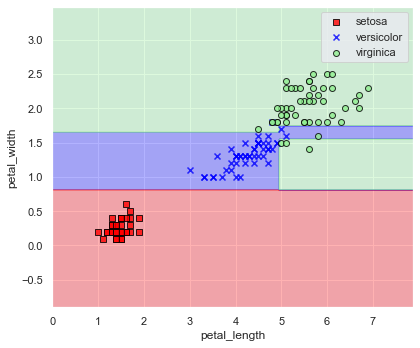

In [16]:
print(f"accuracy score: {accuracy_score(y_true=y, y_pred=model.predict(x)):.6f}")
plot_decision_regions(
    x=x, y=y, model=model, xlabel="petal_length", ylabel="petal_width", encoder=encoder
)

(petal_length, petal_width) = (5, 1.7) あたりは決定境界が怪しいですが，良い感じに品種分割できていますね．  
二分決定木は説明変数を２つに分けていくので，上図のように決定境界も上下／左右分割を繰り返して作成されたものになります．

前回の記事 (https://slash-z.com/svm-support-vector-machine/) で linear SVC では全然ダメだったこちらの分布についても決定木でどうなるかを試してみましょう．
まずはデータ生成していきます．

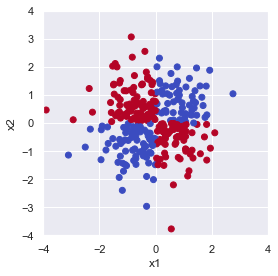

In [17]:
rng = np.random.default_rng(seed=0)
size = 300
# 説明変数
x = rng.normal(size=size*2).reshape((size, 2))
# 目的変数
y = x[:,0]*x[:,1] > 0

fig = plt.figure(facecolor="white")
ax = plt.axes(aspect="equal")
ax.scatter(x[:, 0], x[:, 1], c=y, cmap="coolwarm_r")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
fig.tight_layout()
plt.show()

上図は $x_1 \times x_2$ が 0 より大きくなる点（第１，３象限）を True で青, 0 以下になる点（第２，４象限）を False で赤としてプロットしています．  
では，先ほどと同じパラメータの criterion="gini", max_depth=4 として決定木で学習してみましょう．

accuracy score: 1.000000


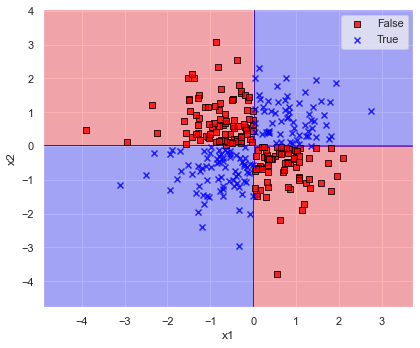

In [24]:
model = tree.DecisionTreeClassifier(criterion="gini", max_depth=4, random_state=0)
model.fit(x, y)
print(f"accuracy score: {accuracy_score(y_true=y, y_pred=model.predict(x)):.6f}")
plot_decision_regions(x=x, y=y, model=model, xlabel="x1", ylabel="x2")

見事にデータを４つの象限で分けることができました．  
人の感性とも合致しているので完璧ですね．

---

## 演習問題

Q1. ワインデータセットについて，以下を参照して，目的変数であるワインの等級を決定木によって求めてください．

- データ分割は train_test_split にて行い，学習用データは全データの 90 %，データのシャッフルは True としてください（結果に再現性を持たせたい場合は，引数 random_state に任意の数を設定してください）
- データは，以下のコードにて読み込むことができます（データの説明はこちら：https://slash-z.com/matplotlib-first-step/）

```python
from sklearn.datasets import load_wine

df_x, df_y = load_wine(return_X_y=True, as_frame=True)
```

- scikit-learn を用いて分類問題における認識精度を確認するには，以下のようにして算出が可能です．

```python
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true, y_pred))
```

Q2. カリフォルニア住宅価格データセットについて，決定木を用いて以下の手順で住宅価格を予測してみましょう．
- 次のコードでデータ読み込み，学習用／検証用にデータを分割します．

```python
from sklearn.datasets import fetch_california_housing

df_x, df_y = fetch_california_housing(return_X_y=True, as_frame=True)
x_train, x_test, y_train, y_test = train_test_split(
    df_x, df_y, test_size=0.25, shuffle=True, random_state=0,
)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
```

- 学習用データ (x_train, y_train) のみを学習し，検証用データ x_test について住宅価格を予測しましょう．
- 上記で予測した住宅価格について，正解の値との絶対平均誤差を算出してみましょう．

以下のコードにて絶対平均誤差が算出できます．
ここで，y_true は正解データの y_test，y_pred には x_test に対するモデルの推論結果を代入してください．

```python
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_true, y_pred))
```

Q3. カルフォルニア大学アーバイン校（UCI）が提供している，手書き数字のデータセット (API: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) について，何の数字かを認識してみましょう．データ読み込みは以下のコードを実行します．

```python
from sklearn.datasets import load_digits

# データ読み込み
x, y = load_digits(return_X_y=True)
```